### 1. GOAL

The goal of this task is to cluster search keywords semantically.

### 2. DATA

The data is from KW Clusters file https://docs.google.com/spreadsheets/d/1pDgWNNaEJqc7oNA8khVheK9uLX7Q6Bu-5L5BxBUoBJs/edit#gid=0 We use only keyword column for clustering.


### 3. TECHNIQUE SUMMARY

    3.1 Load data
    3.2 Tokenize and clean data
    3.3 Train word2vec on custom corpus
    3.4 Cluster keywords using K-Means
    3.5 Visualize clustering result

### 3.1 Load Data

In [64]:
%matplotlib inline

import nltk.data;
from nltk.corpus import stopwords;
import string;

from gensim.models import Word2Vec;
from gensim.models.phrases import Phraser, Phrases;

from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;

import pandas as pd;
import numpy as np;

import os;
import re;
import logging;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;

In [65]:
# get keywords column from KW Clusters excel file
df = pd.read_excel('kw_clusters.xlsx', sheetname='All')
df['keywords']

C:\Users\user\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


0      nectar  website | nectar  mattress store | nec...
1      nectar website  | bb website  | brooklyn beddi...
2      friend  | friend  referred | friend s | friend...
3      leesa  mattress | googled leesa  | leesa  and ...
4      yelp  | yelp , and then visited your new york ...
5      mattress stores  | mattress stores  nyc | bb s...
6      mom  group long island city | my mom  | mom  f...
7      mom group  long island city | facebook group  ...
8                            mom group long  island city
9                            mom group long island  city
10     mom group long island city  | google "new york...
11                                          neighborhood
12     casper  nyc | leesa and casper  showroom | mat...
13     where  to buy saatva bed | where  to try saatv...
14     where to buy  saatva bed | where can i buy  sa...
15     where to buy saatva  bed | where to try saatva...
16     googled brooklyn  bedding | brooklyn  bedding ...
17     winkbeds  | winkbeds  we

### 3.2 Tokenize and Clean Data

In [66]:
# tokenize keywords
df["tokenized_keywords"] = df["keywords"].apply(nltk.word_tokenize)

In [67]:
df["tokenized_keywords"]

0      [nectar, website, |, nectar, mattress, store, ...
1      [nectar, website, |, bb, website, |, brooklyn,...
2      [friend, |, friend, referred, |, friend, s, |,...
3      [leesa, mattress, |, googled, leesa, |, leesa,...
4      [yelp, |, yelp, ,, and, then, visited, your, n...
5      [mattress, stores, |, mattress, stores, nyc, |...
6      [mom, group, long, island, city, |, my, mom, |...
7      [mom, group, long, island, city, |, facebook, ...
8                       [mom, group, long, island, city]
9                       [mom, group, long, island, city]
10     [mom, group, long, island, city, |, google, ``...
11                                        [neighborhood]
12     [casper, nyc, |, leesa, and, casper, showroom,...
13     [where, to, buy, saatva, bed, |, where, to, tr...
14     [where, to, buy, saatva, bed, |, where, can, i...
15     [where, to, buy, saatva, bed, |, where, to, tr...
16     [googled, brooklyn, bedding, |, brooklyn, bedd...
17     [winkbeds, |, winkbeds, 

In [68]:
# convert dataframe to list of list
tokenized_keywords = df["tokenized_keywords"].values.tolist()

In [69]:
tokenized_keywords

[['nectar',
  'website',
  '|',
  'nectar',
  'mattress',
  'store',
  '|',
  'nectar',
  '|',
  'googled',
  'nectar',
  '|',
  'nectar',
  'showroom',
  '|',
  'nectar',
  'try',
  '|',
  'nectar',
  'research',
  '|',
  'nectar',
  'mattress',
  '|',
  'where',
  'to',
  'try',
  'nectar',
  '|',
  'nectar',
  'show',
  'room',
  '|',
  'google',
  '-',
  'nectar',
  'mattress',
  'store',
  '|',
  'online',
  '``',
  'nectar',
  'distributor',
  'page',
  '|',
  'nectar',
  'mattresses',
  '|',
  'nectar',
  'brick',
  'and',
  'motar',
  'store',
  '|',
  'online',
  ';',
  'nectar',
  'try',
  '|',
  'purple',
  'nectar',
  'casper',
  '|',
  'nectar',
  'stores',
  '|',
  'google',
  'nectar',
  'and',
  'purple',
  '|',
  'nectar',
  'matress',
  '|',
  'nectar',
  'vs.',
  '|',
  'google',
  'nectar',
  '|',
  'nectar',
  'showrooms',
  '|',
  'google',
  'nectar',
  'to',
  'try',
  'out',
  '|',
  'try',
  'nectar',
  'mattress',
  '|',
  'nectar',
  'in',
  'store',
  '|',


In [70]:
# Clean keywords
# Convert to lowercase.
# Remove punctuation from each word
# Filter out remaining tokens that are not alphabetic.
# Filter out tokens that are stop words.
def clean_text(list_tokens):
    cleaned_tokens = list()
    for tokens in list_tokens:
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        #nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        cleaned_tokens.append(words)
    return cleaned_tokens

In [71]:
# apply clean_text method to the tokenized_keywords
cleaned_keywords = clean_text(tokenized_keywords)

In [72]:
cleaned_keywords

[['nectar',
  'website',
  'nectar',
  'mattress',
  'store',
  'nectar',
  'googled',
  'nectar',
  'nectar',
  'showroom',
  'nectar',
  'try',
  'nectar',
  'research',
  'nectar',
  'mattress',
  'try',
  'nectar',
  'nectar',
  'show',
  'room',
  'google',
  'nectar',
  'mattress',
  'store',
  'online',
  'nectar',
  'distributor',
  'page',
  'nectar',
  'mattresses',
  'nectar',
  'brick',
  'motar',
  'store',
  'online',
  'nectar',
  'try',
  'purple',
  'nectar',
  'casper',
  'nectar',
  'stores',
  'google',
  'nectar',
  'purple',
  'nectar',
  'matress',
  'nectar',
  'vs',
  'google',
  'nectar',
  'nectar',
  'showrooms',
  'google',
  'nectar',
  'try',
  'try',
  'nectar',
  'mattress',
  'nectar',
  'store',
  'nectar',
  'new',
  'york',
  'city',
  'nectar',
  'try',
  'casper',
  'nectar',
  'nectar',
  'ecosa',
  'nectar',
  'bed',
  'new',
  'york',
  'nectar',
  'bed',
  'nectar',
  'website',
  'nectar',
  'mattress',
  'nyc',
  'try',
  'nectar',
  'try',


In [73]:
len(cleaned_keywords)

288

In [74]:
# create bigram and trigram model
bigram = Phrases(cleaned_keywords, min_count=1) # higher threshold fewer phrases.
trigram = Phrases(bigram[cleaned_keywords])

2019-12-21 18:18:49,118 : INFO : collecting all words and their counts
2019-12-21 18:18:49,120 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-12-21 18:18:49,129 : INFO : collected 2251 word types from a corpus of 4495 words (unigram + bigrams) and 288 sentences
2019-12-21 18:18:49,130 : INFO : using 2251 counts as vocab in Phrases<0 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
2019-12-21 18:18:49,130 : INFO : collecting all words and their counts
2019-12-21 18:18:49,132 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-12-21 18:18:49,154 : INFO : collected 2348 word types from a corpus of 3721 words (unigram + bigrams) and 288 sentences
2019-12-21 18:18:49,155 : INFO : using 2348 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [75]:
trigram_mod = Phraser(trigram)

2019-12-21 18:18:49,160 : INFO : source_vocab length 2348
2019-12-21 18:18:49,190 : INFO : Phraser built with 20 phrasegrams


In [76]:
# new data with bigram and trigram keywords
cleaned_keywords = list(trigram_mod[cleaned_keywords])

In [77]:
cleaned_keywords

[['nectar',
  'website',
  'nectar',
  'mattress',
  'store',
  'nectar',
  'googled',
  'nectar',
  'nectar',
  'showroom',
  'nectar',
  'try',
  'nectar',
  'research',
  'nectar',
  'mattress',
  'try',
  'nectar',
  'nectar',
  'show',
  'room',
  'google',
  'nectar',
  'mattress',
  'store',
  'online',
  'nectar',
  'distributor',
  'page',
  'nectar',
  'mattresses',
  'nectar',
  'brick',
  'motar',
  'store',
  'online',
  'nectar',
  'try',
  'purple',
  'nectar',
  'casper',
  'nectar',
  'stores',
  'google',
  'nectar',
  'purple',
  'nectar',
  'matress',
  'nectar',
  'vs',
  'google',
  'nectar',
  'nectar',
  'showrooms',
  'google',
  'nectar',
  'try',
  'try',
  'nectar',
  'mattress',
  'nectar',
  'store',
  'nectar',
  'new',
  'york',
  'city',
  'nectar',
  'try',
  'casper',
  'nectar',
  'nectar',
  'ecosa',
  'nectar',
  'bed',
  'new',
  'york',
  'nectar',
  'bed',
  'nectar',
  'website',
  'nectar',
  'mattress',
  'nyc',
  'try',
  'nectar',
  'try',


### 3.3 Train Word2Vec on Custom Corpus
We create Word2Vec model using our own data

In [78]:
start = time.time()

# set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# set values for various parameters
num_features = 50    # Dimensionality of the hidden layer representation
min_word_count = 25   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count()      # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       

# initialize and train the model
print("Training model...")
model = Word2Vec(cleaned_keywords, workers=num_workers, size=num_features, min_count = min_word_count, window = context)

# save the model
model_name = "model_keywords"
model.save(model_name)

print('Total time: ' + str((time.time() - start)) + ' secs')

2019-12-21 18:18:49,278 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-12-21 18:18:49,279 : INFO : collecting all words and their counts
2019-12-21 18:18:49,280 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-21 18:18:49,282 : INFO : collected 456 word types from a corpus of 4299 raw words and 288 sentences
2019-12-21 18:18:49,282 : INFO : Loading a fresh vocabulary
2019-12-21 18:18:49,283 : INFO : effective_min_count=25 retains 31 unique words (6% of original 456, drops 425)
2019-12-21 18:18:49,284 : INFO : effective_min_count=25 leaves 2365 word corpus (55% of original 4299, drops 1934)
2019-12-21 18:18:49,285 : INFO : deleting the raw counts dictionary of 456 items
2019-12-21 18:18:49,286 : INFO : sample=0.001 downsamples 31 most-common words
2019-12-21 18:18:49,287 : INFO : downsampling leaves estimated 467 word corpus (19.8% of prior 2365)
2019-12-21 18:18:49,287 : INFO : estimated required memory for 31 w

Training model...
Total time: 0.1130061149597168 secs


In [79]:
# total vocabulary
len(list(model.wv.vocab))

31

In [80]:
list(model.wv.vocab)

['nectar',
 'website',
 'mattress',
 'store',
 'googled',
 'showroom',
 'try',
 'google',
 'online',
 'mattresses',
 'purple',
 'casper',
 'stores',
 'showrooms',
 'new',
 'york',
 'city',
 'nyc',
 'leesa',
 'best',
 'test',
 'brooklyn_bedding',
 'winkbed',
 'saatva',
 'airweave',
 'walk',
 'friend',
 'referral',
 'refer',
 'review',
 'map']

In [81]:
# get word vector for each words in vocab
keyword_vectors = model.wv.vectors

In [82]:
len(keyword_vectors)

31

### 3.4 Cluster Keywords Using K-Means
We will cluster the keywords using KMeans. Since the keywords are represented as vectors, applying KMeans is easy to do since the clustering algorithm will simply look at differences between vectors (and centers).

In [83]:
def clustering_keywordvecs(keyword_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++')
    idx = kmeans_clustering.fit_predict(keyword_vectors)
    
    return kmeans_clustering.cluster_centers_, idx

Text(0.5, 1.0, 'Elbow curve')

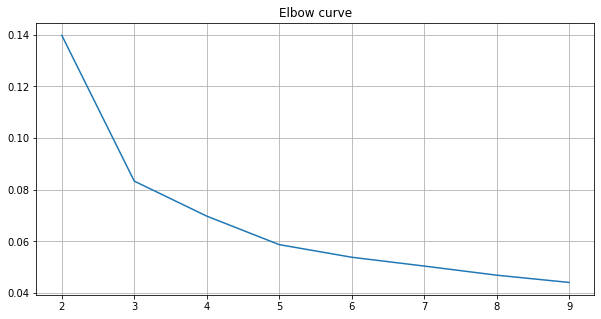

In [84]:
# get optimal k clusters
X = keyword_vectors
distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [85]:
# apply KMeans clustering to the keywords data with K=2
centers, clusters = clustering_keywordvecs(keyword_vectors, 3)

In [86]:
centroid_map = dict(zip(model.wv.index2word, clusters))
centroid_map

{'mattress': 2,
 'try': 1,
 'google': 1,
 'saatva': 2,
 'nectar': 1,
 'store': 0,
 'purple': 1,
 'casper': 2,
 'showroom': 1,
 'website': 1,
 'online': 0,
 'nyc': 0,
 'leesa': 1,
 'stores': 1,
 'best': 1,
 'friend': 1,
 'test': 0,
 'brooklyn_bedding': 1,
 'new': 0,
 'york': 1,
 'googled': 0,
 'mattresses': 0,
 'winkbed': 1,
 'review': 1,
 'city': 0,
 'map': 1,
 'refer': 2,
 'walk': 0,
 'showrooms': 0,
 'referral': 0,
 'airweave': 0}

In [87]:
# get words in each cluster that are closest to the cluster center
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs)

    # closest points for each Cluster center is used to query the closest 10 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers]
    closest_words_idxs = [x[1] for x in closest_points]

    # word index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    # a DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words)
    df.index = df.index+1

    return df

In [88]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [89]:
top_words = get_top_words(model.wv.index2word, 10, centers, keyword_vectors)

In [90]:
top_words

,Cluster #01,Cluster #02,Cluster #03
1,store,try,mattress
2,mattresses,brooklyn_bedding,saatva
3,city,winkbed,refer
4,googled,best,casper
5,online,nectar,website
6,walk,stores,google
7,showrooms,friend,winkbed
8,new,york,purple
9,test,review,try
10,airweave,purple,nectar


### 3.5 Visualize Clustering Result

In [91]:
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="white", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

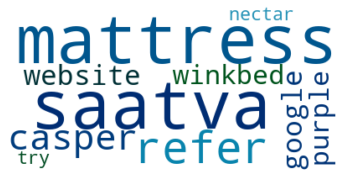

In [93]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

for i in range(3):
    col = next(cmaps)
    display_cloud(i+1, col)

![title](./cluster_1.png)<br>
![title](./cluster_2.png)<br>
![title](./cluster_3.png)

### 4. NOTES

    1. Adding trigram feature but seems did not work in word like ['new', 'york', 'city']. We need to find other solutions for this issue so that we can add feature of phrase variations.
    
    2. For now, we created word2vec model using our own limited data. We need to build big domain corpus if we want to identify next keywords and create good semantic model. We can crawl domain website using current vocabularies. Then we create word2vec model again from the corpus and add the current data to the model.
    
    3. To find optimal k in k-means clustering, elbow method still give us choices of k. In our case, it can be k=3, k=4, or k=5. We need to try other metrics.